dataset:

---


https://github.com/liaopeiyuan/artbench

In [ ]:
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

[link text](https://www.kaggle.com/datasets/alexanderliao/artbench10)
**EDA, are there painting genres('label' column) only for one artist or for multiple artist. Based on documentaion dataset only contains balanced genres: 10 distinctive artistic styles, with 5,000 training images and 1,000 testing images per style. But there is no information, how are artistis distributed across genres and how does body of work differ per artist**

In [ ]:
###
url = "https://artbench.eecs.berkeley.edu/files/ArtBench-10.csv"
df = pd.read_csv(url)
df.columns

Index(['name', 'artist', 'url', 'is_public_domain', 'length', 'width', 'label',
       'split', 'cifar_index'],
      dtype='object')

In [ ]:
df[df['split'] == 'train'].shape[0], df[df['split'] == 'test'].shape[0]

(50000, 10000)

In [ ]:
# unique artists
len(df['artist'].unique())

2126

In [ ]:
#  art styles, only single art style is present per painting
df['label'].unique()

array(['impressionism', 'romanticism', 'expressionism', 'surrealism',
       'art_nouveau', 'renaissance', 'realism', 'post_impressionism',
       'baroque', 'ukiyo_e'], dtype=object)

In [ ]:
body_of_work = df.groupby('artist').size().reset_index(name='count').sort_values(by='count', ascending=True)

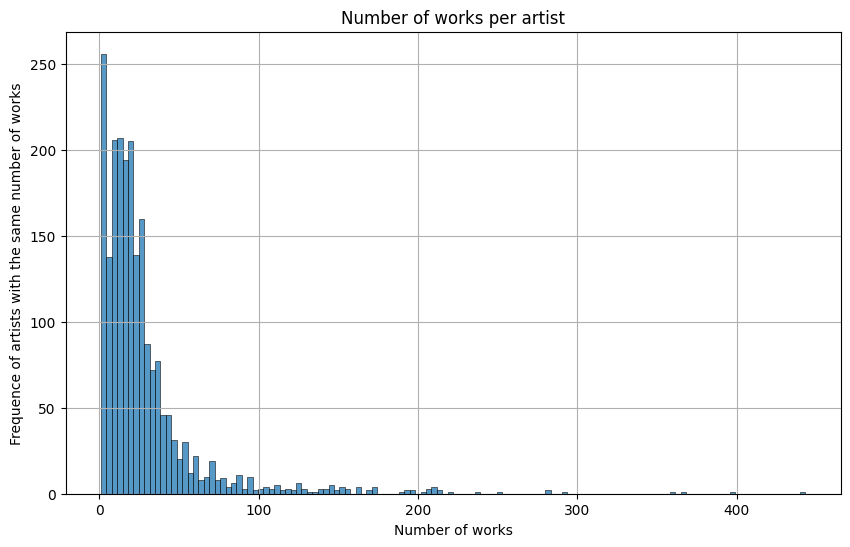

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=body_of_work, x='count')
plt.title('Number of works per artist')
plt.xlabel('Number of works')
plt.ylabel('Frequence of artists with the same number of works')
plt.grid(True)
plt.show()

In [ ]:
body_of_work.describe()

,count
count,2126.000000
mean,28.222013
std,36.317924
min,1.000000
25%,10.000000
50%,19.000000
75%,32.000000
max,443.000000


there are plenty of artist that have paintings in multiple genres

In [ ]:
df[df['artist'] == 'pablo-picasso'].groupby('label').size()

,0
label,
art_nouveau,15
expressionism,27
impressionism,18
post_impressionism,99
realism,20
surrealism,32


chat gpt recommended, ordering of the genres based on eras:



1.  Renaissance (14th - 17th century)
1.  Baroque (17th - mid-18th century)
1.  Ukiyo-e (17th - 19th century, though often associated with the Edo period in Japan)
1.  Romanticism (late 18th - mid-19th century)
1.  Realism (mid-19th century)
1.  Impressionism (late 19th century)
1.  Post-Impressionism (late 19th - early 20th century)
1.  Art Nouveau (late 19th - early 20th century)
1.  Expressionism (early 20th century)
1.  Surrealism (1920s - 1940s)




In [ ]:
genres_sorted = [
                'renaissance',
                'baroque',
                'ukiyo_e',
                'romanticism',
                'realism',
                'impressionism',
                'post_impressionism',
                'art_nouveau',
                'expressionism',
                'surrealism',
            ]

In [ ]:
all_labels = df['label'].drop_duplicates().sort_values(key= lambda el: el.map(lambda x: genres_sorted.index(x))).unique()
all_labels

array(['renaissance', 'baroque', 'ukiyo_e', 'romanticism', 'realism',
       'impressionism', 'post_impressionism', 'art_nouveau',
       'expressionism', 'surrealism'], dtype=object)

**Analysis of how many artists have paintings in other genres**

In [ ]:
artist_number_of_genres = df.groupby('artist')['label'].nunique().reset_index(name='genres_count').sort_values(by='genres_count', ascending=False)

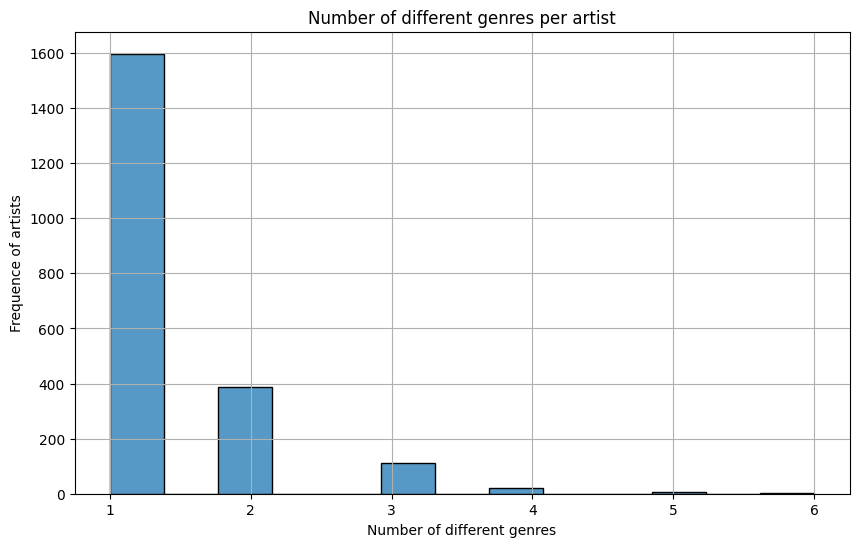

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=artist_number_of_genres, x='genres_count')
plt.title('Number of different genres per artist')
plt.xlabel('Number of different genres')
plt.ylabel('Frequence of artists')
plt.grid(True)
plt.show()

**While it is common for artist appear in other genres, it rare that they appear in more than 3**

In [ ]:
genre_limit = 3
print('The number of artists with works in more that {genre_limit} genres : {count}'.format(count=len(artist_by_genres[artist_by_genres > 3]), genre_limit=genre_limit))

The number of artists with works in more that 3 genres : 30


In [ ]:
MAX_GENRE_PER_ARTISTS = df.groupby('artist')['label'].nunique().sort_values(ascending=False).iloc[0]
print('Largest number of genres per painter: {count}'.format(count=MAX_GENRE_PER_ARTISTS))

Largest number of genres per painter: 6


**Now we know that certain artist appear in more than one genre, but we don't know for each genre how common is it for artist to appen in other genres, are some genres more "pure" than others**

In [ ]:
# for each genre, how many artists are in the other genre
artist_by_genre_number = pd.DataFrame(0, index=all_labels, columns=range(1, MAX_GENRE_PER_ARTISTS + 1))

# Iterate through each artist
for artist, artist_df in df.groupby('artist'):
    artist_labels = artist_df['label'].unique()

    for label in artist_labels:
      artist_by_genre_number.loc[label, len(artist_labels)] += 1



**For certain genres it is actualy more common for painter to appear in other gernres than jus this one, Since genres for which this is true appear chronologically, this means overlap between genre time periods**

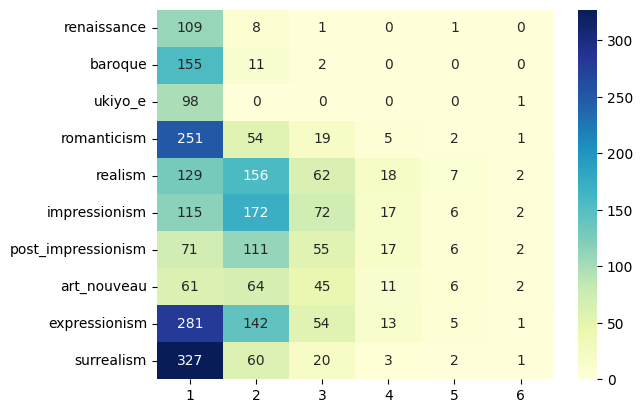

In [ ]:

sns.heatmap(artist_by_genre_number, cmap="YlGnBu", annot=True, fmt="0.0f")
plt.show()

**Is there a correlation between certain genres, how often they have artist that appear in both of them, display this as confussion matrix**

In [151]:
# wheater to include the information, that artist is present only in one genre or not
# this is already present in upper diagram
FLAG_DIAGONAL_EMPTY = True

In [152]:
# Show artist where multiple styles are present, this is vizualized as a confussion matrix
common_styles_matrix = pd.DataFrame(0, index=all_labels, columns=all_labels)

# Iterate through each artist
for _, artist_df in df.groupby('artist'):
    artist_labels = artist_df['label'].unique()

    if len(artist_labels) == 1 and FLAG_DIAGONAL_EMPTY:
      continue

    # artist appears only in one genre
    if len(artist_labels) == 1:
        common_styles_matrix.loc[artist_labels[0], artist_labels[0]] += 1
        continue

    # count both pairs, no need for normalization, since datasets classes are evenly present in the dataset
    for pair in itertools.combinations(artist_labels, 2):
      common_styles_matrix.loc[pair[0], pair[1]] += 1
      common_styles_matrix.loc[pair[1], pair[0]] += 1



This heatmap shows how often there are painters inside the genre, that occur in other genres. A lot of artists with impressionism paintings, also appear in realism paintings.

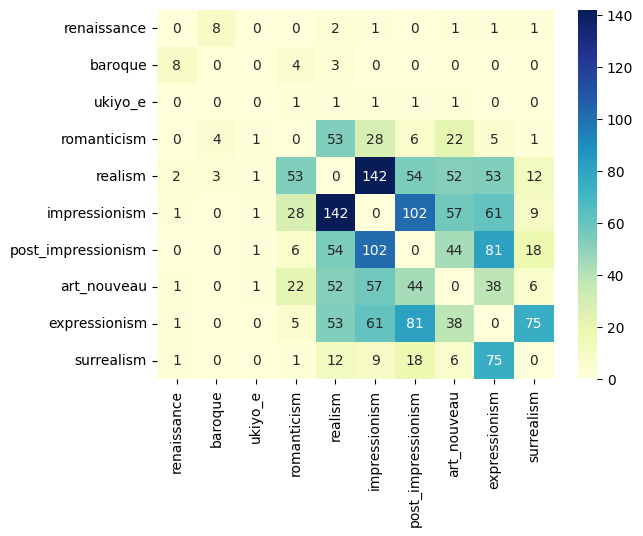

In [153]:
sns.heatmap(common_styles_matrix, cmap="YlGnBu", annot=True, fmt="0.0f")
plt.show()

In [154]:
artist_inside_genre = df.groupby('label')['artist'].unique().map(lambda x: len(x)).sort_index(key= lambda el: el.map(lambda x: genres_sorted.index(x))).reset_index(name='artist_count')
artist_inside_genre['single_style_ratio'] = artist_by_genre_number[1].values / artist_inside_genre['artist_count'].values
artist_inside_genre

,label,artist_count,single_style_ratio
0,renaissance,119,0.915966
1,baroque,168,0.922619
2,ukiyo_e,99,0.989899
3,romanticism,332,0.756024
4,realism,374,0.344920
5,impressionism,384,0.299479
6,post_impressionism,262,0.270992
7,art_nouveau,189,0.322751
8,expressionism,496,0.566532
9,surrealism,413,0.791768


**Visual comparison of number of unique artist per genre, and how often painters in this genre appear in other genres**

<Axes: xlabel='artist_count', ylabel='label'>

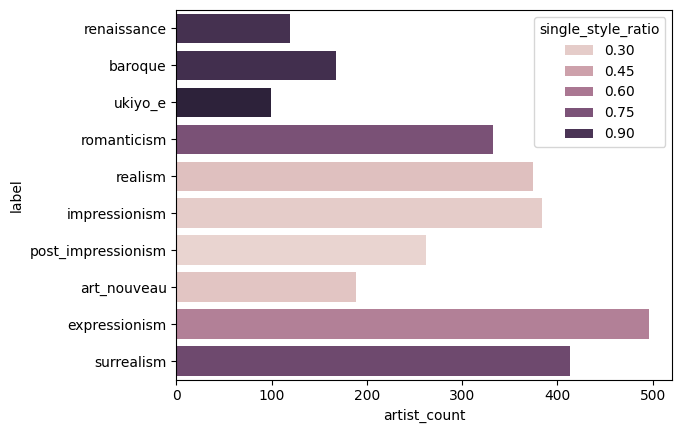

In [156]:
sns.barplot(y='label', x='artist_count', hue='single_style_ratio', data=artist_inside_genre)